Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

Импорт модулей:

In [104]:
!python -m pip install spacy -q 
!python -m spacy download en -q
!python -m pip install profanityfilter -q
!python -m pip install pyspellchecker -q

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/vykers/anaconda3/envs/p36/lib/python3.6/site-packages/en_core_web_sm -->
/home/vykers/anaconda3/envs/p36/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [105]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sps
import lightgbm as lgb
from profanityfilter import ProfanityFilter
from spellchecker import SpellChecker

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import spacy
spacy.prefer_gpu()
nlp = spacy.load('en', disable=['parser', 'ner'])

stopwords_ = set(stopwords.words('english'))
    
R = 10000

In [106]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/vykers/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /home/vykers/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vykers/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Откроем датасет:

In [107]:
dirname = './datasets/'
comments = pd.read_csv(dirname + 'toxic_comments.csv')  #запуск в хабе Практикума

comments.sample(5, random_state=R)

,text,toxic
78757,That's not universally correct. Many non-Chris...,0
28455,User:Abd is muslim cr@p,1
146262,January 2010 \n Please stop your disruptive ed...,0
49009,I think I've made it clear why I've chosen to ...,1
147635,Mariana Championship \n\nWanted to let you kno...,0


Изучим информацию о таблице:

In [108]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


В таблице 159571 запись, пропусков нет. 

# 2. Анализ данных

### Изучение классов и текстов сообщений:
Изучим соотношение классов целевого признака:

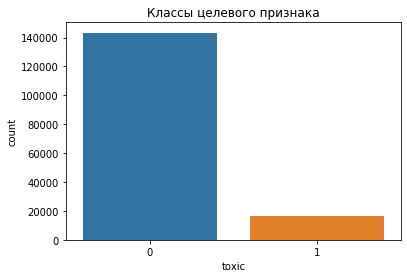

In [109]:
sns.countplot(comments['toxic']).set_title('Классы целевого признака')
plt.show()

Имеется сильный дисбаланс классов - "токсичных" записей намного меньше, чем обычных.

Посмотрим на несколько примеров для каждого класса:

In [110]:
print('Нормальные комментарии:')
for x, y in comments.query('toxic == 0').sample(4, random_state=R).values:
    print('\nTEXT:', x[: 300], '\nTOXIC:', y)

Нормальные комментарии:

TEXT: "

Endorse. Please take a look at this diff  where David states having anti-Islamic sentiment. In order to cite one example, please take a look at this diff  where he renames ""Listed terrorist organisations"" to ""Islam-inspired listed terrorist organisations"".  " 
TOXIC: 0

TEXT: (personal opinion, but I can't imagine that you would openly lie, given the administration powers). 
TOXIC: 0

TEXT: May 2013 (UTC)
No worries.  Is it correct that I ask users for a co-nomination statement?  Just want to be sure I don't inadvertently breach WP:CANVASS.  And would you say there's an appropriate number of co-nominators to seek?  Looking through the past RFAs it seems to range from none to two.  Hope 
TOXIC: 0

TEXT: Re:Disam 

Why thank you! ) I really appreciate that. Yes, it's all done manually. I never have mastered TWINKLE or any of the other tools. Anyway, I truly appreciate the compliment. It means alot to me. Woohoo! 
TOXIC: 0


In [111]:
print('Токсичные комментарии:')
for x, y in comments.query('toxic == 1').sample(4, random_state=R).values:
    print('\nTEXT:', x[: 300], '\nTOXIC:', y)

Токсичные комментарии:

TEXT: The EA Prayer 

Dear lord, please let EA not fuck this one up, like they fucked up Renegade and Generals... amen. 
TOXIC: 1

TEXT: WIKIBITCH 

YO LIL PUNKASS AINT SHIT OUT ON DA STREETS NIGGA 
TOXIC: 1

TEXT: NOOOO! 

How dare you block my best enemy Yesmoredonkeys from Wikipedia? His articles were the best thing there. Now nothing can replace him, not even your ugly face! Now nobody will want to visit Wikipedia, jerk! Now I am going to give you two options: suffer the consequences, or pay the price. Pic 
TOXIC: 1

TEXT: Eric W.Bragg's Surrealism: SIDEWALK STAINS

In my lifetime, I have seen some of the most stupidest crap that my eyes have unfortunately seen! However, this tops them all, Eric W.Bragg presents, SIDEWALK STAINS! (I am not making this up):

http://www.surrealcoconut.com/surrealism_gallery/Found_Object 
TOXIC: 1


Можно заметить, что в текстах сообщений присутствуют URL-адреса, юзернеймы, различная капитализация слов, пунктуация и прочие символы.

Проанализируем такую величину, как количество символов в тексте комментария:

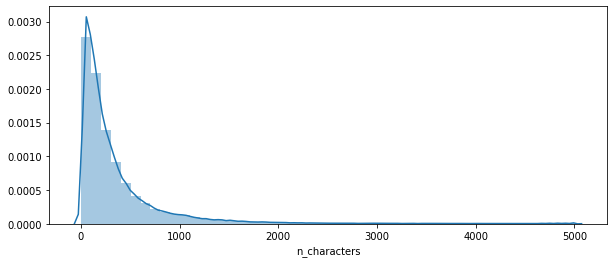

In [112]:
comments['n_characters'] = comments['text'].str.len()
plt.figure(figsize=(10,4))
sns.distplot(comments['n_characters'])
plt.show()

Можно видеть, что большая часть комментариев не превышает 500 - 1000 знаков. Максимальный размер сообщения равен 5000. Посмотрим ради примера на несколько таких сообщений.

In [113]:
(comments.loc[comments['n_characters'] == 5000, 'text']
         .head(3)
         .str.slice(0, 300)                          # ограничим вывод
         .values)

array(['ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, ',
       'SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SECURITYFUCK H',
       'BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS BALLS '],
      dtype=object)

Видим, что в основном такие длинные комментарии являются копипастом одной-двух коротких фраз до достижения лимита знаков. Наличие таких спам-сообщений может повлиять на работу модели (испортить статистику использования различных слов), поэтому далее мы разберемся, как их исправить.

Посмотрим также на самые короткие сообщения:

In [114]:
comments.sort_values('n_characters').head(5)

,text,toxic,n_characters
137062,~ J.Lo,0,6
52442,"14:53,",0,6
109985,{{unbloc,0,8
121074,you suck,1,8
118850,FUCK YOU,1,8


Как видим, среди коротких сообщений есть и бессмысленные, и осмысленные тексты.

### Создание дополнительных признаков

Прежде чем приступить к очистке и векторизации текстов комментариев, попробуем извлечь из них метапризнаки, которые могут коррелировать с классом целевой переменной. В качестве таких признаков предлагается рассмотреть:

- Количество слов, предложений и абзацев в комментарии;
- Количество слов, набранных капсом;
- Количество стоп-слов;
- Количество знаков препинания (восклицательных, вопросительных и остальных.

Информация об этих признаках пропадет после очистки текста, так что их следует создать заранее. После очистки текста дополнительно выделим следующие признаки:
- Количество уникальных слов;
- Количество мата;
- Количество опечаток.

При этом, с учетом большого разброса комментариев по длине признаки будем нормировать относительно количества знаков:

In [115]:
#Слова
comments['num_words'] = comments['text'].apply(lambda t: len(t.split()))
#Капс
comments['n_caps'] = comments['text'].apply(lambda t: sum(1 for c in t if c.isupper()))
#Стоп-слова
comments['n_stopwords'] = comments['text'].apply(lambda t: sum(t.count(w) for w in set(stopwords_)))
#Воскл. знаки
comments['n_excl_marks'] = comments['text'].apply(lambda t: t.count('!'))
#Вопр. знаки
comments['n_q_marks'] = comments['text'].apply(lambda t: t.count('?'))
#Пунктуация
comments['n_punkt'] = comments['text'].apply(lambda t: sum(t.count(w) for w in string.punctuation))
#Абзацы
comments['n_paragraphs'] = comments['text'].apply(lambda t: t.count('\n') + 1)
#Предложения
comments['n_sentences']=comments["text"].apply(lambda x: len(sent_tokenize(x)))

#Нормализация
for column in comments.iloc[:, 3:].columns:
    comments[column + '_norm'] = comments[column] / comments['n_characters']

Посмотрим на таблицу:

In [116]:
comments.head()

,text,toxic,n_characters,num_words,n_caps,n_stopwords,n_excl_marks,n_q_marks,n_punkt,n_paragraphs,n_sentences,num_words_norm,n_caps_norm,n_stopwords_norm,n_excl_marks_norm,n_q_marks_norm,n_punkt_norm,n_paragraphs_norm,n_sentences_norm
0,Explanation\nWhy the edits made under my usern...,0,264,43,17,143,0,1,10,2,3,0.162879,0.064394,0.541667,0.000000,0.003788,0.037879,0.007576,0.011364
1,D'aww! He matches this background colour I'm s...,0,112,17,8,41,1,0,12,1,4,0.151786,0.071429,0.366071,0.008929,0.000000,0.107143,0.008929,0.035714
2,"Hey man, I'm really not trying to edit war. It...",0,233,42,4,159,0,0,6,1,3,0.180258,0.017167,0.682403,0.000000,0.000000,0.025751,0.004292,0.012876
3,"""\nMore\nI can't make any real suggestions on ...",0,622,113,11,369,0,0,21,5,4,0.181672,0.017685,0.593248,0.000000,0.000000,0.033762,0.008039,0.006431
4,"You, sir, are my hero. Any chance you remember...",0,67,13,2,36,0,1,5,1,2,0.194030,0.029851,0.537313,0.000000,0.014925,0.074627,0.014925,0.029851


### Очистка текста

Очистим текст сообщений от знаков препинания, ссылок, юзернеймов и прочих ненужных символов. Определим функцию clean_text:

In [117]:
def clean_text(text):
    
    username_pattern = re.compile(r'user\S*')                 #юзернеймы
    url_pattern = re.compile(r'https?://\S+|www\.\S+')        #ссылки
    html_tag_pattern = re.compile(r'<.*?>')                   #html-тэги
    char_pattern = re.compile(r'[^a-z]')                      #все, кроме латинских букв
    for pattern in [username_pattern, url_pattern, html_tag_pattern, char_pattern]:
        text = pattern.sub(r' ',text.lower())
    return ' '.join([w for w in text.split() if (1 < len(w) < 25)]) #ограничим длину слов

#Проверка
example = "<b>User:john should CHECK out http://www.ya.ru \U0001F600!!!\nIt's cool</b>"
print('Проверка: до очистки:', example)
print('\nПосле очистки:', clean_text(example))

Проверка: до очистки: <b>User:john should CHECK out http://www.ya.ru 😀!!!
It's cool</b>

После очистки: should check out it cool


Применим функцию clean_text к столбцу с комментариями:

In [118]:
comments['clean_text'] = comments['text'].apply(clean_text)
comments.drop(columns=['text'], inplace=True)

Прежде чем продолжить, выделим еще несколько признаков: количество уникальных слов, мата и опечаток:

In [119]:
#Уникальные слова
comments['n_unique_words'] = comments['clean_text'].apply(lambda t: len(set(w for w in t.split())))
comments['unique_words_norm'] = comments['n_unique_words'] / comments['n_characters']

Для мата воспользуемся словарем из модуля ProfanityFilter:

In [120]:
#Мат
pf = ProfanityFilter()
badwords = set(x.lower() for x in pf.get_profane_words())

comments['n_profanities'] = comments['clean_text'].apply(lambda t: len([w for w in t.split() if w in badwords]))
comments['prof_norm'] = comments['n_profanities'] / comments['n_characters']

Для подсчета опечаток используем модуль pyspellchecker. Исправлять опечатки не будем (функция correct на нашем датасете работает слишком долго):

In [121]:
#Опечатки
sc = SpellChecker()

comments['n_typos'] = comments['clean_text'].apply(lambda t: len(sc.unknown(t.split())))
comments['typos_norm'] = comments['n_typos'] / comments['n_characters']

На основании количества уникальных слов произведем обрезку спам-комментов. Спамом будем считать комментарии, у которых большая длина, а количество уникальных слов мало:

In [122]:
def spam_trimmer(inp):
    text, n_unique, unique_norm = inp.values
    if 0 < unique_norm < 0.02:                   
        text = ' '.join(text.split()[0: 2 * n_unique])
    return text
#Проверка
print(comments.query('0 < unique_words_norm < 0.02').tail(1)['clean_text'].str.slice(0, 300).values)
print('\n', comments.query('0 < unique_words_norm < 0.02').tail(1)
      [['clean_text', 'n_unique_words', 'unique_words_norm']].apply(spam_trimmer, axis=1).values)

['hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia hi wikipedia h']

 ['hi wikipedia hi wikipedia']


Применим функцию к тексту:

In [123]:
comments['clean_text'] = (comments[['clean_text', 'n_unique_words', 'unique_words_norm']]
                          .apply(spam_trimmer, axis=1))

### Изучение признаков

Мы создали большое количество дополнительных признаков. Посмотрим, как они коррелируют с целевой переменной, и на основании этого отберем из них самые важные:

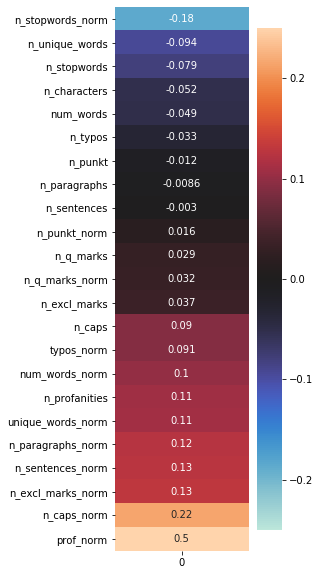

In [124]:
new_features = comments.drop(columns = ['clean_text', 'toxic']).columns

correlations = [comments[f].corr(comments['toxic']) for f in new_features]
correlations = pd.DataFrame(index = new_features, data = correlations).sort_values(0)

plt.figure(figsize=(3,10))
sns.heatmap(correlations, annot=True, vmin=-0.25, vmax=0.25, center=0.0)
plt.show()

Видим следующее:
1. Корреляция с нормированными признаками проявляется сильнее, чем с обычными, что логично, учитывая большую разницу в длине комментариев;
2. Наиболее сильно целевой признак связан с количеством ругательств и количеством слов, набранных капсом (что вполне логично). Также положительная корреляция присутствует с относительным количеством восклицательных знаков, предложений и абзацев;
3. Отрицательная корреляция выявлена с количеством стоп-слов и, в меньшей степени, уникальных слов.

Оставим только те признаки, у которых коэффициент корреляции по модулю не меньше 0.09:

In [125]:
comments = comments.drop(columns=correlations.loc[abs(correlations[0]) < 0.09].index)
comments.shape

(159571, 13)

In [126]:
comments.to_csv('comments_after_cleaning.csv', index=False) #Промежуточное сохранение
# comments = pd.read_csv('comments_after_cleaning.csv')

Перед тем, как переходить к лемматизации текста и рассчету TF/IDF, проверим, нет ли комментариев, у которых в поле **clean_text** после всех преобразований ничего не осталось:

In [127]:
comments.loc[comments['clean_text'] == ''].head()

,toxic,num_words_norm,n_caps_norm,n_stopwords_norm,n_excl_marks_norm,n_paragraphs_norm,n_sentences_norm,clean_text,n_unique_words,unique_words_norm,n_profanities,prof_norm,typos_norm
1490,0,0.200000,0.023077,0.200000,0.0,0.030769,0.007692,,0,0.0,0,0.0,0.0
4482,0,0.171875,0.000000,0.000000,0.0,0.328125,0.015625,,0,0.0,0,0.0,0.0
6063,1,0.521739,0.000000,0.173913,0.0,0.043478,0.043478,,0,0.0,0,0.0,0.0
6193,0,0.028169,0.000000,0.281690,0.0,0.014085,0.014085,,0,0.0,0,0.0,0.0
6300,0,0.100000,0.000000,0.000000,0.0,0.050000,0.050000,,0,0.0,0,0.0,0.0


Такие записи есть (в них содержались либо URL-адреса, либо числа, символы и отдельные буквы, которые мы удалили). Чтобы избежать ошибок в дальнейшем, заполним пропуски в поле **clean_text** значением "no_text".

In [128]:
comments.loc[comments['clean_text'] == '', 'clean_text'] = 'no_text'

### Лемматизация
Произведем лемматизацию текста с использованием библиотеки spaCy. Определим функцию lemmatize_text:

In [129]:
def lemmatize_text(text):
    res = []
    sentence = nlp(text)
    for token in sentence:
        lemm = token.lemma_
        if lemm not in stopwords_:
            res.append(lemm)
    return ' '.join(res)
print(comments['clean_text'][2], '\n')
print(lemmatize_text(comments['clean_text'][2]))

hey man really not trying to edit war it just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info 

hey man really try edit war -PRON- guy constantly remove relevant information talk -PRON- edit instead -PRON- talk page -PRON- seem care formatting actual info


Применим функцию к столбцу **clean_text**:

In [130]:
comments['clean_text'] = comments['clean_text'].apply(lemmatize_text)

In [131]:
# comments.to_csv('comments_after_lemmatization.csv', index=False) #Промежуточное сохранение
# comments = pd.read_csv('comments_after_lemmatization.csv')

# 3. Векторизация текста
### TF/IDF для слов
Произведем рассчет TF/IDF для текстов. Рассчет следует проводить по тренировочной выборке, так что разобьем датасет на тренировочную и тестовую часть:

In [132]:
feats = comments.drop(columns=['toxic'])
target = comments['toxic']
train_feats, test_feats, train_target, test_target = train_test_split(feats, target, 
                                                                      test_size=0.2, 
                                                                      random_state=R) 
print(f'''Размеры выборок:

Обучающая \t {train_feats.shape[0]}
Тестовая \t {test_feats.shape[0]}''')

Размеры выборок:

Обучающая 	 127656
Тестовая 	 31915


Создадим корпусы из обучающей и тестовой выборок:

In [133]:
train_corpus = train_feats['clean_text'].values.astype('U')
test_corpus = test_feats['clean_text'].values.astype('U')

Создадим векторизатор TF/IDF и обучим его на тренировочной выборке, после чего векторизуем весь датасет:

In [134]:
tfidf = TfidfVectorizer(sublinear_tf=True, max_features=100000)

tf_idf_train = tfidf.fit_transform(train_corpus)
tf_idf_test = tfidf.transform(test_corpus)

Посмотрим на размер полученной матрицы:

In [135]:
tf_idf_train.shape

(127656, 100000)

Не забудем также добавить к выборкам рассчитанные на прошлом шаге метапризнаки, предварительно нормировав их с помощью RobustScaler. Результаты векторизации сохранены в виде разреженной матрицы, так что рассчетные признаки также переведем в этот вид:

In [136]:
num_features = train_feats.drop(columns = ['clean_text']).columns

skl = RobustScaler()

train_num_features = sps.csr_matrix(skl.fit_transform(train_feats[num_features]))
test_num_features = sps.csr_matrix(skl.transform(test_feats[num_features]))
all_train_features = sps.hstack([tf_idf_train, train_num_features]).tocsr()
all_test_features = sps.hstack([tf_idf_test, test_num_features]).tocsr()

In [137]:
# sps.save_npz('train_features_tf.npz', all_train_features)
# sps.save_npz('test_features_tf.npz', all_test_features)

### Символьные n-граммы

Рассчитаем также TF/IDF для n-грамм символов (n возьмем равным 3):

In [138]:
char_vectorizer = TfidfVectorizer(
    analyzer='char_wb',         #n-граммы будут браться в границах слов
    ngram_range=(3, 3))
tf_idf_char_train = char_vectorizer.fit_transform(train_corpus)
tf_idf_char_test = char_vectorizer.transform(test_corpus)

Добавим полученные векторы к нашей матрице признаков:

In [139]:
all_train_features = sps.hstack([all_train_features, tf_idf_char_train]).tocsr()
all_test_features = sps.hstack([all_test_features, tf_idf_char_test]).tocsr()
all_train_features.shape

(127656, 113717)

# 3. Обучение моделей

### Логистическая регрессия
Обучим модель логистической регрессии:

In [140]:
logreg_model = LogisticRegression(solver='liblinear', max_iter=200)
logreg_model.fit(all_train_features, train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Найдем значение f1-меры на тестовом наборе:

In [150]:
lr_predictions = logreg_model.predict(all_test_features)
print('F1 для логистической регрессии', f1_score(lr_predictions, test_target))

F1 для логистической регрессии 0.7860473147988257


Получили значение f1 в районе 0.78, что вполне неплохо и укладывается в задание (более 0.75).

### LGBM

Попробуем улучшить результат линейной модели. Построим модель градиентного бустинга с использованием Light-GBM:

Преобразуем выборки в формат lgb.Dataset:

In [142]:
train_lgb = lgb.Dataset(all_train_features, train_target)
test_lgb = lgb.Dataset(all_test_features, test_target)

Определим свою функцию валидации (Light-GBM предсказывает не класс, а вероятность класса наблюдения, что не подходит для рассчета f1-меры): 

In [143]:
def lgb_f1(pred, data):
    y_true = data.get_label()
    pred = np.where(pred < 0.7, 0, 1)
    return 'f1', f1_score(y_true, pred), True

Обучим модель на тренировочном датасете:

params = {'boosting_type': 'gbdt',
          'objective': 'binary',
          'is_unbalance': True,
          'seed': R,
          'max_depth': 15,
          'feature_fraction': 0.4,
          'learning_rate': 0.1
         }

lgb_model = lgb.train(params=params, train_set=train_lgb, num_boost_round=675, feval=lgb_f1,
                      valid_sets=[train_lgb], verbose_eval=50)

Проверим работу модели на тестовом наборе:

In [176]:
predictions = lgb_model.predict(all_test_features)
predictions =  np.where(predictions > 0.7, 1, 0)
print('F1 для LGBM', f1_score(predictions, test_target))

F1 для LGBM 0.8098569157392688


В итоге при использовании модели градиентного бустинга мы смогли получить значение F1 около 0.81.